<a href="https://colab.research.google.com/github/ShannonBonilla/COMM557_Project/blob/main/RQ2_TikTok_vs_Spotify_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ShannonBonilla/COMM557_Project.git
%cd COMM557_Project
from pathlib import Path; import pandas as pd, numpy as np, re, glob, matplotlib.pyplot as plt
DATA = Path("data"); OUT = Path("outputs"); OUT.mkdir(exist_ok=True)


Cloning into 'COMM557_Project'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 75 (delta 29), reused 10 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 9.93 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/COMM557_Project


In [2]:
def clean_name(x):
    if not isinstance(x,str): return ""
    x = re.sub(r'\s*\([^)]*\)', '', x); x = re.sub(r'feat\..*','',x,flags=re.I)
    return re.sub(r'[^a-z0-9]+',' ',x.lower()).strip()
def keyify(t,a): return f"{clean_name(t)} — {clean_name(a)}"

songs  = pd.read_csv(DATA/"final_songs_with_lyrics.csv")
topics = pd.read_csv(DATA/"dataset_with_topics.csv")
for d in (songs, topics):
    d.columns = [c.strip().lower().replace(" ","_") for c in d.columns]
    if "track_name" in d.columns:  d.rename(columns={"track_name":"title"}, inplace=True)
    if "artist_name" in d.columns: d.rename(columns={"artist_name":"artist"}, inplace=True)
songs["key"]  = [keyify(t,a) for t,a in zip(songs["title"], songs["artist"])]
topics = topics.rename(columns={"topic_number":"topic"}) if "topic_number" in topics.columns else topics
topics = topics[["title","artist","topic"]].dropna(subset=["topic"]).copy()
topics["key"] = [keyify(t,a) for t,a in zip(topics["title"], topics["artist"])]
df = songs.merge(topics[["key","topic"]], on="key", how="inner")
df["topic"] = pd.to_numeric(df["topic"], errors="coerce").dropna().astype(int)


In [3]:
# TikTok keys
tt_frames=[]
for p in sorted(glob.glob(str(DATA/"TikTok_songs_*.csv"))):
    d = pd.read_csv(p); d.columns = [c.strip().lower().replace(" ","_") for c in d.columns]
    tcol = "title" if "title" in d.columns else ("track_name" if "track_name" in d.columns else None)
    acol = "artist" if "artist" in d.columns else ("artist_name" if "artist_name" in d.columns else None)
    if tcol and acol:
        d["key"] = [keyify(str(t),str(a)) for t,a in zip(d[tcol], d[acol])]
        tt_frames.append(d[["key"]])
tiktok_keys = set(pd.concat(tt_frames, ignore_index=True)["key"].drop_duplicates())

# Spotify keys (+ weeks)
sp_frames=[]
for p in sorted(glob.glob(str(DATA/"spotify_top_charts_*.csv"))):
    d = pd.read_csv(p); d.columns = [c.strip().lower().replace(" ","_") for c in d.columns]
    if {"track_name","artist_names"}.issubset(d.columns):
        first_artist = d["artist_names"].astype(str).str.split(",").str[0]
        out = pd.DataFrame({"key":[keyify(t,a) for t,a in zip(d["track_name"], first_artist)]})
        if "weeks_on_chart" in d.columns: out["weeks_on_chart"] = d["weeks_on_chart"]
        sp_frames.append(out)
spotify_df   = pd.concat(sp_frames, ignore_index=True).drop_duplicates()
spotify_keys = set(spotify_df["key"])
spotify_weeks = (spotify_df.groupby("key")["weeks_on_chart"].max()
                 if "weeks_on_chart" in spotify_df.columns else pd.Series(dtype=float))


In [4]:
df["on_tiktok"]  = df["key"].isin(tiktok_keys)
df["on_spotify"] = df["key"].isin(spotify_keys)
def label_group(r):
    if r["on_spotify"] and r["on_tiktok"]: return "TikTok-Crossover"
    if r["on_spotify"] and not r["on_tiktok"]: return "Spotify-Only"
    return "Other"
df["group"] = df.apply(label_group, axis=1)


In [7]:
# Rebuild the RQ2 subset from df (must already contain: title, artist, topic, group)
assert "group" in df.columns and "topic" in df.columns, "df must have group and topic columns"
df_rq2 = df[df["group"].isin(["TikTok-Crossover","Spotify-Only"])].copy()
print("RQ2 rows:", len(df_rq2), "| groups:\n", df_rq2["group"].value_counts())

RQ2 rows: 1783 | groups:
 group
Spotify-Only        1513
TikTok-Crossover     270
Name: count, dtype: int64


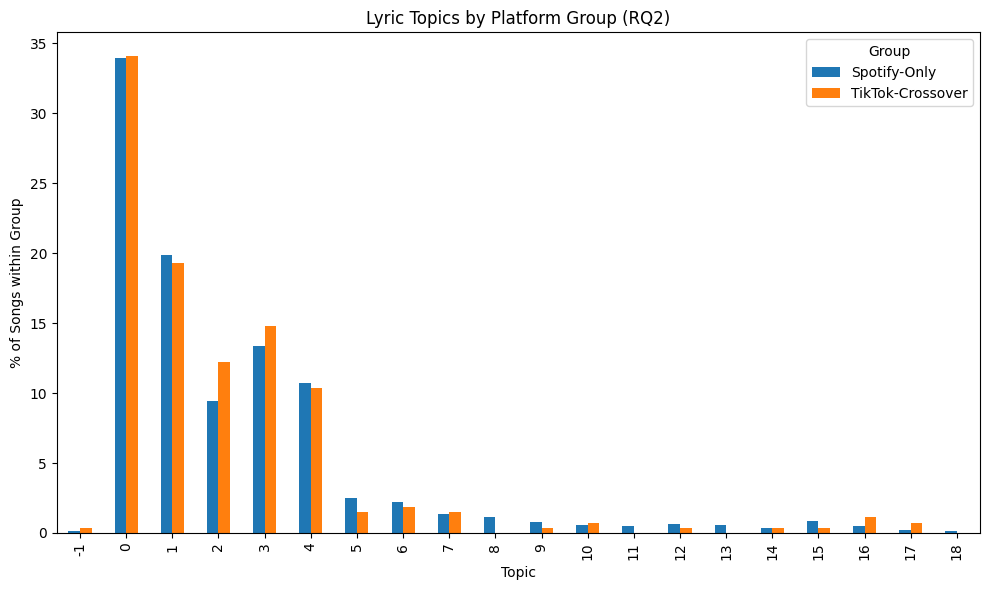

No weeks column found in df_rq2 — skipped longevity export.


In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA = Path("data")

# --- Topic distribution (always runs)
topic_counts = (
    df_rq2.groupby(["group","topic"]).size()
          .reset_index(name="count")
)
topic_counts["pct_within_group"] = (
    topic_counts["count"] /
    topic_counts.groupby("group")["count"].transform("sum") * 100.0
)
topic_counts.to_csv(DATA/"topic_distribution_tiktok_vs_spotify.csv", index=False)

pivot = topic_counts.pivot(index="topic", columns="group", values="pct_within_group").fillna(0)
ax = pivot.plot(kind="bar", figsize=(10,6))
ax.set_title("Lyric Topics by Platform Group (RQ2)")
ax.set_ylabel("% of Songs within Group")
ax.set_xlabel("Topic")
ax.legend(title="Group")
plt.tight_layout(); plt.show()
# plt.savefig("outputs/rq2_topics_bar.png", dpi=200, bbox_inches="tight")

# --- Optional longevity export (only if weeks column exists)
weeks_col = None
for c in ["weeks_on_chart", "weeks_on_cf_chart_long", "weeks"]:
    if c in df_rq2.columns:
        weeks_col = c
        break

if weeks_col:
    lon = (
        df_rq2.groupby(["group","topic"])[weeks_col]
              .mean().reset_index()
              .rename(columns={weeks_col: "avg_weeks"})
    )
    lon.to_csv(DATA/"topic_avg_weeks_by_group.csv", index=False)
    print("Saved topic_avg_weeks_by_group.csv")
else:
    print("No weeks column found in df_rq2 — skipped longevity export.")
